## Задание 07 

In [1]:
import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline
import networkx as nx
import pandas as pd

import ndlib.models.epidemics.SIModel as si
import ndlib.models.epidemics.SISModel as sis
import ndlib.models.epidemics.SIRModel as sir
import ndlib.models.ModelConfig as mc

### 1. Влияние топологии на характерное время распространение эпидемии в SI модели.

* Сгенерируйте случайные графы из разных моделей: Эрдеша-Реньи, Барабаши-Альберта, Ваттса-Строгатца. 

Число вершин всех графов $N=10^4$, а средняя степень у всех примерно одинакова и, например, $\left< k\right>\approx10$. 

* Смоделируйте SI модель, изобразите на одном графике среднюю долю инфицированных от времени для разных графов.  

Параметры модели SI - $\beta$ и число шагов по времени - подберите самостоятельно. Усреднение можно проводить по 100 запускам SI (Не по графам!!!).

На этом же графике изобразите кривую, отвечающую приближению среднего поля. 

* Видите ли вы отличия в распространении эпидемии? Объясните результаты. 

In [35]:
n = 10000
Ge = nx.erdos_renyi_graph(n, 0.001, seed=1234)
#Gb = nx.barabasi_albert_graph(n, m, seed=1234)
#Gw = nx.watts_strogatz_graph(n, 10, 0.5, seed=1234)

In [36]:
from IPython.display import clear_output
desE = np.zeros((150, 100))
model = si(Ge)
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.01)
model.set_initial_status(cfg)

for j in range(100):
    model.reset()
    for i in range(150):
        stat = model.get_status_map()
        it = model.iteration()
        desE[i][j] = it['node_count'][1]
    clear_output()
    print(j)

99


In [45]:
Gb = nx.barabasi_albert_graph(n, 10, seed=1234)
desB = np.zeros((150, 100))
model = si(Gb)
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.01)
model.set_initial_status(cfg)

for j in range(100):
    model.reset()
    for i in range(150):
        stat = model.get_status_map()
        it = model.iteration()
        desB[i][j] = it['node_count'][1]
    clear_output()
    print(j)

99


In [46]:
Gw = nx.watts_strogatz_graph(n, 10, 0.5, seed=1234)
desW = np.zeros((150, 100))
model = si(Gw)
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.01)
cfg.add_model_parameter('lambda', 0.005)
model.set_initial_status(cfg)

for j in range(100):
    model.reset()
    for i in range(150):
        stat = model.get_status_map()
        it = model.iteration()
        desW[i][j] = it['node_count'][1]
    clear_output()
    print(j)

99


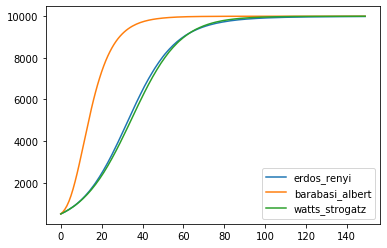

In [59]:
plt.plot(range(150), np.mean(desE, 1), label="erdos_renyi")
plt.plot(range(150), np.mean(desB, 1), label="barabasi_albert")
plt.plot(range(150), np.mean(desW, 1), label="watts_strogatz")
plt.legend()

In [ ]:
Различие есть. Модель барбаши альберта 

### 2. Порог зажигания в модели SIS.
Рассмотрим модель SIS с параметром $\mu=1$ на двух графах из задания 1: Эрдеша-Реньи и Барабаши-Альберта. 
Так как $\left< k\right>\approx10$ и $\mu=1$, то пороговое значение $\beta$, выше которого  эпидемия не затухает из приближения среднего поля:
$$
\beta=\frac{1}{\left< k\right>}\approx 0.1,
$$

Постройте зависимость средней доли зараженных в сетях от параметра $\beta$, $\beta \in\left[0,0.2 \right]$. Усреднение проводите по 100 запускам SIS. Число шагов по времени (итераций) определите самостоятельно. 

In [66]:
Ge = nx.erdos_renyi_graph(n, 0.001, seed=1234)
betas = np.arange(0, 0.22, 0.02)
berd = []
for b in betas:
    model = sis(Ge)
    cfg = mc.Configuration()
    cfg.add_model_parameter('lambda', 1)
    cfg.add_model_parameter('beta', b)
    model.set_initial_status(cfg)
    buf = []
    for j in range(1):
        model.reset()
        buf.append(model.iteration_bunch(150)[-1]['node_count'][1])
    berd.append(np.mean(buf))
    clear_output()
    print(b)

0.18


In [67]:
Gb = nx.barabasi_albert_graph(n, 10, seed=1234)
betas = np.arange(0, 0.22, 0.02)
barb = []
for b in betas:
    model = sis(Gb)
    cfg = mc.Configuration()
    cfg.add_model_parameter('lambda', 1)
    cfg.add_model_parameter('beta', b)
    model.set_initial_status(cfg)
    buf = []
    for j in range(100):
        model.reset()
        buf.append(model.iteration_bunch(150)[-1]['node_count'][1])
    barb.append(np.mean(buf))
    clear_output()
    print(b)

0.18


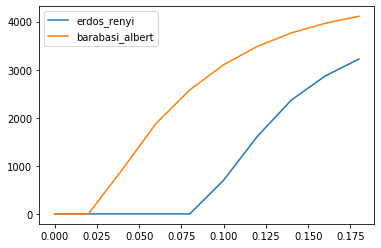

In [68]:
plt.plot(betas, berd, label="erdos_renyi")
plt.plot(betas, barb, label="barabasi_albert")
plt.legend()

### 3. Влияние топологии в модели SIR.
Рассмотрим модель SIR на следующих сетях: 

In [2]:
G1=nx.read_graphml('graph1.graphml')
G2=nx.read_graphml('graph2.graphml')

* Постройте зависимости средней доли зараженных вершин в модели SIR для первого и второго графа.

Параметры для моделирования:

In [3]:
beta=0.005
gamma=0.03
percentage_infected=0.002
n_iter=200 # число шагов моделирования
n_run=100 # число запусков распространения для усреднения

In [6]:
from IPython.display import clear_output
model = sir(G1)
cfg = mc.Configuration()
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
cfg.add_model_parameter('percentage_infected', percentage_infected)
model.set_initial_status(cfg)

des1 = np.zeros((n_iter, n_run))
for j in range(n_run):
    model.reset()
    for i in range(n_iter):
        stat = model.get_status_map()
        it = model.iteration()
        des1[i][j] = it['node_count'][1]
    clear_output()
    print(j)

99


In [9]:
model = sir(G2)
cfg = mc.Configuration()
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
cfg.add_model_parameter('percentage_infected', percentage_infected)
model.set_initial_status(cfg)

des2 = np.zeros((n_iter, n_run))
for j in range(n_run):
    model.reset()
    for i in range(n_iter):
        stat = model.get_status_map()
        it = model.iteration()
        des2[i][j] = it['node_count'][1]
    clear_output()
    print(j)

99


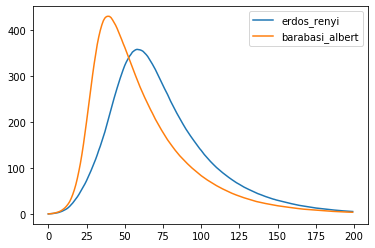

In [13]:
plt.plot(range(n_iter), np.mean(des1, 1), label="erdos_renyi")
plt.plot(range(n_iter), np.mean(des2, 1), label="barabasi_albert")
plt.legend()

* Отличаются ли построенные зависимости? 
Попробуйте понять, что влияет на распространение в сети, для этого исследуйте топологию G1, G2. 

In [14]:
beta=0.01
gamma=0.05
percentage_infected=0.002
n_iter=200 # число шагов моделирования
n_run=100 # число запусков распространения для усреднения

In [15]:
from IPython.display import clear_output
model = sir(G1)
cfg = mc.Configuration()
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
cfg.add_model_parameter('percentage_infected', percentage_infected)
model.set_initial_status(cfg)

des1 = np.zeros((n_iter, n_run))
for j in range(n_run):
    model.reset()
    for i in range(n_iter):
        stat = model.get_status_map()
        it = model.iteration()
        des1[i][j] = it['node_count'][1]
    clear_output()
    print(j)

99


In [16]:
model = sir(G2)
cfg = mc.Configuration()
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
cfg.add_model_parameter('percentage_infected', percentage_infected)
model.set_initial_status(cfg)

des2 = np.zeros((n_iter, n_run))
for j in range(n_run):
    model.reset()
    for i in range(n_iter):
        stat = model.get_status_map()
        it = model.iteration()
        des2[i][j] = it['node_count'][1]
    clear_output()
    print(j)

99


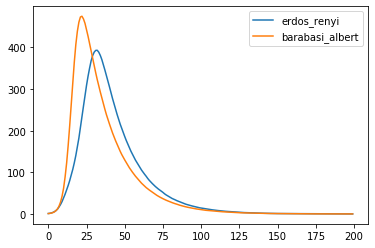

In [17]:
plt.plot(range(n_iter), np.mean(des1, 1), label="erdos_renyi")
plt.plot(range(n_iter), np.mean(des2, 1), label="barabasi_albert")
plt.legend()

In [18]:
beta=0.05
gamma=0.1
percentage_infected=0.01
n_iter=200 # число шагов моделирования
n_run=100 # число запусков распространения для усреднения

In [19]:
from IPython.display import clear_output
model = sir(G1)
cfg = mc.Configuration()
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
cfg.add_model_parameter('percentage_infected', percentage_infected)
model.set_initial_status(cfg)

des1 = np.zeros((n_iter, n_run))
for j in range(n_run):
    model.reset()
    for i in range(n_iter):
        stat = model.get_status_map()
        it = model.iteration()
        des1[i][j] = it['node_count'][1]
    clear_output()
    print(j)

99


In [20]:
model = sir(G2)
cfg = mc.Configuration()
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
cfg.add_model_parameter('percentage_infected', percentage_infected)
model.set_initial_status(cfg)

des2 = np.zeros((n_iter, n_run))
for j in range(n_run):
    model.reset()
    for i in range(n_iter):
        stat = model.get_status_map()
        it = model.iteration()
        des2[i][j] = it['node_count'][1]
    clear_output()
    print(j)

99


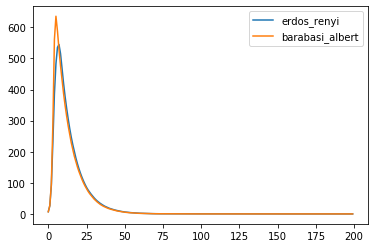

In [21]:
plt.plot(range(n_iter), np.mean(des1, 1), label="erdos_renyi")
plt.plot(range(n_iter), np.mean(des2, 1), label="barabasi_albert")
plt.legend()

* Поменяйте параметры модели, всегда ли распространение "чувствительно" к топологии сети?

### 4. Моделирование распространения Covid-19. 
Будем работать с [данными](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset) по распространению коронавируса в мире. 

* Визуализируйте данные для выбранных стран, например в виде зависимостей логарифма числа зараженных от времени. 

* Оцените коэффициет роста числа зараженных - коэффициент в экспоненциальной зависимости, как его можно интерпретировать? 

* (дополнительно) Попробуйте смоделировать распространение в рамках SIR модели (в приближении среднего поля) для провинции Хубей (Китай). 

* (дополнительно) Какие прогнозы можно сделать по ситуации в России? 

In [23]:
import pandas as pd
data = pd.read_csv("covid.csv")
data.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,55,56,58,69,77,82,84,93,112,113
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,0,0,0,2,6,6,6,6,6,6
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,100,127,174,239,286,316,316,452,475,513
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,22,0,0,30,30,30,37,40,42,43


In [28]:
dsum = data.iloc[:,11:]
dsum.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,55,56,58,69,77,82,84,93,112,113
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,6,6,6,6,6,6
3,0,0,0,0,0,0,0,0,0,0,...,100,127,174,239,286,316,316,452,475,513
4,0,0,0,0,0,0,0,0,0,0,...,22,0,0,30,30,30,37,40,42,43


In [34]:
cor = np.array(dsum.sum(axis=0))

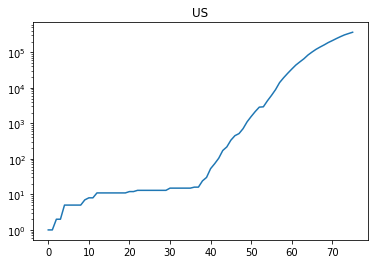

In [40]:
plt.plot(range(len(cor)), cor)
plt.yscale("log")
plt.title("US")
plt.show()